In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import check_grad
import matplotlib.pyplot as plt
import random
random.seed(42)

In [ ]:
#load training set (60K images)
X_tr = np.load("kmnist-train-imgs.npz")["arr_0"]
y_tr = np.load("kmnist-train-labels.npz")["arr_0"]

#load test set (10K images)
X_te = np.load("kmnist-test-imgs.npz")["arr_0"]
y_te = np.load("kmnist-test-labels.npz")["arr_0"]

#flatten 28x28 images into 784-dimensional vectors
X_tr_flat = X_tr.reshape(X_tr.shape[0], -1)
X_te_flat = X_te.reshape(X_te.shape[0], -1)

#split training data into train and validation sets (10% val)
X_train_flat, X_val_flat, y_tr, y_val = train_test_split(
    X_tr_flat, y_tr, test_size=0.1, random_state=42, stratify=y_tr)

#standardize (fit on training only, apply to val and test)
scaler = StandardScaler()
X_tr_std = scaler.fit_transform(X_train_flat)
X_val_std = scaler.transform(X_val_flat)
X_te_std = scaler.transform(X_te_flat)


In [ ]:
#verify proper data scaling and shaping

print("Training set shape:", X_tr_std.shape)
print("Test set shape:", X_te_std.shape)

print("Mean of training set", np.mean(X_tr_std))
print("Std of training set", np.std(X_tr_std))

Training set shape: (54000, 784)
Test set shape: (10000, 784)
Mean of training set 1.4071216687010299e-18
Std of training set 0.9999999999999988


Task 2: Implement MLP Model

In [ ]:
#functions for loss, output, activation, and accuracy evaluation
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    correct_log_probs = -np.log(y_pred[range(n_samples), y_true])
    return np.mean(correct_log_probs)

def evaluate_acc(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [ ]:
class MLP:
    def __init__(self, input_size, hidden_layers, activation='relu', output_size=10):
        self.layer_sizes = [input_size] + hidden_layers + [output_size]
        self.num_layers = len(self.layer_sizes) - 1

        if activation == 'relu':
            self.activation = relu
            self.activation_derivative = relu_derivative
        elif activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative
        elif activation == 'leaky_relu':
            self.activation = leaky_relu
            self.activation_derivative = leaky_relu_derivative
        else:
            raise ValueError("Unsupported activation function.")

        self.weights = []
        self.biases = []

        for i in range(self.num_layers):
            w = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * 0.01
            b = np.zeros((1, self.layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        activations = [X]
        pre_activations = []

        A = X
        for i in range(self.num_layers - 1):
            Z = A @ self.weights[i] + self.biases[i]
            pre_activations.append(Z)
            A = self.activation(Z)
            activations.append(A)

        #output layer
        Z = A @ self.weights[-1] + self.biases[-1]
        pre_activations.append(Z)
        A = softmax(Z)
        activations.append(A)

        return activations, pre_activations

    def backward(self, activations, pre_activations, y_true):
        n = y_true.shape[0]
        grads_w = [None] * self.num_layers
        grads_b = [None] * self.num_layers

        #output layer gradient
        dZ = activations[-1]
        dZ[range(n), y_true] -= 1
        dZ /= n

        grads_w[-1] = activations[-2].T @ dZ
        grads_b[-1] = np.sum(dZ, axis=0, keepdims=True)

        #hidden layers
        for i in reversed(range(self.num_layers - 1)):
            dA = dZ @ self.weights[i+1].T
            dZ = dA * self.activation_derivative(pre_activations[i])
            grads_w[i] = activations[i].T @ dZ
            grads_b[i] = np.sum(dZ, axis=0, keepdims=True)

        return grads_w, grads_b


    def update_parameters(self, grads_w, grads_b, lr, reg_lambda, reg_type='l2'):
      for i in range(self.num_layers):
          if reg_type == 'l2':
              reg_term = reg_lambda * self.weights[i]
          elif reg_type == 'l1':
              reg_term = reg_lambda * np.sign(self.weights[i])
          else:
              reg_term = 0.0

          self.weights[i] -= lr * (grads_w[i] + reg_term)
          self.biases[i] -= lr * grads_b[i]

    def fit(self, X, y, lr=0.5, num_epochs=10, batch_size=64, reg_lambda=0.0, reg_type='l2'):
        n_samples = X.shape[0]
        train_acc_per_epoch = []

        for epoch in range(num_epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                activations, pre_activations = self.forward(X_batch)
                grads_w, grads_b = self.backward(activations, pre_activations, y_batch)

                self.update_parameters(grads_w, grads_b, lr, reg_lambda, reg_type)

            y_pred_train = self.predict(X)
            acc = evaluate_acc(y, y_pred_train)
            train_acc_per_epoch.append(acc)

            y_hat = self.forward(X)[0][-1]
            loss = cross_entropy_loss(y, y_hat)
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Train Acc: {acc:.4f}")

        return train_acc_per_epoch


    def predict(self, X):
        probs = self.forward(X)[0][-1]
        return np.argmax(probs, axis=1)



In [ ]:
#testing out model
mlp = MLP(input_size=784, hidden_layers=[32, 32], activation='relu', output_size=10)

mlp.fit(X_tr_std, y_tr, lr=0.5, num_epochs=5, batch_size=128)

y_pred = mlp.predict(X_te_std)
acc = evaluate_acc(y_te, y_pred)
print("Test accuracy:", acc)


Epoch 1/5, Loss: 0.3498, Train Acc: 0.8888
Epoch 2/5, Loss: 0.2995, Train Acc: 0.9071
Epoch 3/5, Loss: 0.2237, Train Acc: 0.9292
Epoch 4/5, Loss: 0.3226, Train Acc: 0.8995
Epoch 5/5, Loss: 0.1934, Train Acc: 0.9404
Test accuracy: 0.8295


In [ ]:
#check gradient:
def full_gradient_check(model, X_sample, y_sample, epsilon=1e-5):
    """
    Performs gradient checking for **all weights in all layers** of the MLP.

    Parameters:
        model: instance of the MLP class
        X_sample: small input batch (e.g. X_tr_std[:5])
        y_sample: corresponding labels
        epsilon: small perturbation for finite differences

    Prints relative error for each layer and average total relative error.
    """
    #run forward + backward pass once to get backprop gradients
    activations, pre_activations = model.forward(X_sample)
    grads_w, grads_b = model.backward(activations, pre_activations, y_sample)

    total_relative_error = 0
    total_weights = 0

    for layer in range(model.num_layers):
        W = model.weights[layer]
        grad_backprop = grads_w[layer]

        #iterate over each element in W
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                original_value = W[i, j]

                #numerical gradient
                W[i, j] = original_value + epsilon
                loss_plus = cross_entropy_loss(y_sample, model.forward(X_sample)[0][-1])

                W[i, j] = original_value - epsilon
                loss_minus = cross_entropy_loss(y_sample, model.forward(X_sample)[0][-1])

                W[i, j] = original_value  # Reset

                grad_num = (loss_plus - loss_minus) / (2 * epsilon)
                grad_bp = grad_backprop[i, j]

                #relative error
                rel_error = abs(grad_bp - grad_num) / (abs(grad_bp) + abs(grad_num) + 1e-8)
                total_relative_error += rel_error
                total_weights += 1

                if rel_error > 1e-5:
                    print(f"W[{layer}][{i},{j}] - Rel error: {rel_error:.2e}")

    avg_rel_error = total_relative_error / total_weights
    print(f"\nAverage relative error across all weights: {avg_rel_error:.2e}")



In [ ]:
#gradient check
X_sample = X_tr_std[:3]
y_sample = y_tr[:3]

test_model = MLP(input_size=784, hidden_layers=[3], activation='relu', output_size=10)

full_gradient_check(test_model, X_sample, y_sample)



Average relative error across all weights: 1.36e-08


Hyperparameter Selection



 Training with learning rate: 0.001
Epoch 1/5, Loss: 2.3026, Train Acc: 0.0688
Epoch 2/5, Loss: 2.3026, Train Acc: 0.0688
Epoch 3/5, Loss: 2.3026, Train Acc: 0.0688
Epoch 4/5, Loss: 2.3026, Train Acc: 0.0685
Epoch 5/5, Loss: 2.3026, Train Acc: 0.0693
Validation accuracy for lr=0.001: 0.0693

 Training with learning rate: 0.005
Epoch 1/5, Loss: 2.3025, Train Acc: 0.1025
Epoch 2/5, Loss: 2.3025, Train Acc: 0.1052
Epoch 3/5, Loss: 2.3025, Train Acc: 0.1063
Epoch 4/5, Loss: 2.3025, Train Acc: 0.1127
Epoch 5/5, Loss: 2.3025, Train Acc: 0.1152
Validation accuracy for lr=0.005: 0.1152

 Training with learning rate: 0.01
Epoch 1/5, Loss: 2.3026, Train Acc: 0.1032
Epoch 2/5, Loss: 2.3026, Train Acc: 0.1060
Epoch 3/5, Loss: 2.3026, Train Acc: 0.1088
Epoch 4/5, Loss: 2.3025, Train Acc: 0.1125
Epoch 5/5, Loss: 2.3025, Train Acc: 0.1163
Validation accuracy for lr=0.01: 0.1163

 Training with learning rate: 0.05
Epoch 1/5, Loss: 2.3026, Train Acc: 0.1150
Epoch 2/5, Loss: 2.3025, Train Acc: 0.1105
E

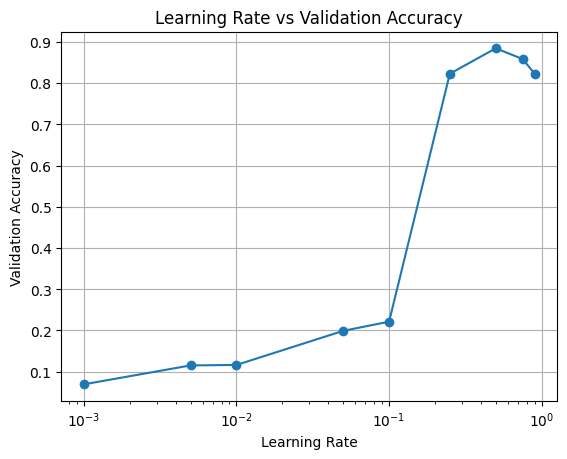

In [ ]:
#find optimal learning rate

learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9]
val_accuracies = []
num_epochs = 5

for lr in learning_rates:
    print(f"\n Training with learning rate: {lr}")
    model = MLP(input_size=784, hidden_layers=[32, 32], activation='relu', output_size=10)
    model.fit(X_val_std, y_val, lr=lr, num_epochs=num_epochs, batch_size=128)
    y_val_pred = model.predict(X_val_std)
    val_acc = evaluate_acc(y_val, y_val_pred)
    val_accuracies.append(val_acc)
    print(f"Validation accuracy for lr={lr}: {val_acc:.4f}")

plt.plot(learning_rates, val_accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate vs Validation Accuracy')
plt.grid(True)
plt.show()

Experiments

In [ ]:
#EXPERIMENT 1 creating three different models
hidden_sizes = [32, 64, 128, 256]

#no hidden layer
no_hidden_MLP = MLP(input_size=784, hidden_layers=[], activation='relu', output_size=10)
no_hidden_MLP.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128)
y_pred_nhMLP = no_hidden_MLP.predict(X_val_std)
best_acc_no = evaluate_acc(y_val, y_pred_nhMLP)
print(f"No Hidden Layer MLP - Validation Accuracy: {best_acc_no:.4f}")

#single hidden layer
best_acc_single = -1
best_size_single = None

for size in hidden_sizes:
    model = MLP(input_size=784, hidden_layers=[size], activation='relu', output_size=10)
    model.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128)
    y_pred = model.predict(X_val_std)
    acc = evaluate_acc(y_val, y_pred)
    print(f"Single Hidden Layer ({size}) - Validation Accuracy: {acc:.4f}")

    if acc > best_acc_single:
        best_acc_single = acc
        best_size_single = size

print(f"\n Best Single Hidden Layer Size: {best_size_single} with Accuracy: {best_acc_single:.4f}")

#double hidden layer
best_acc_double = -1
best_size_double = None

for size in hidden_sizes:
    model = MLP(input_size=784, hidden_layers=[size, size], activation='relu', output_size=10)
    model.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128)
    y_pred = model.predict(X_val_std)
    acc = evaluate_acc(y_val, y_pred)
    print(f"Double Hidden Layers ({size}, {size}) - Validation Accuracy: {acc:.4f}")

    if acc > best_acc_double:
        best_acc_double = acc
        best_size_double = size

print(f"\n Best Double Hidden Layer Size: ({best_size_double}, {best_size_double}) with Accuracy: {best_acc_double:.4f}")


Epoch 1/10, Loss: 0.8869, Train Acc: 0.7816
Epoch 2/10, Loss: 0.8714, Train Acc: 0.7859
Epoch 3/10, Loss: 0.8589, Train Acc: 0.7917
Epoch 4/10, Loss: 0.8492, Train Acc: 0.7894
Epoch 5/10, Loss: 0.8238, Train Acc: 0.7964
Epoch 6/10, Loss: 0.8668, Train Acc: 0.7929
Epoch 7/10, Loss: 0.8748, Train Acc: 0.7781
Epoch 8/10, Loss: 0.8165, Train Acc: 0.7873
Epoch 9/10, Loss: 0.8213, Train Acc: 0.7966
Epoch 10/10, Loss: 0.8062, Train Acc: 0.8004
No Hidden Layer MLP - Validation Accuracy: 0.7727
Epoch 1/10, Loss: 0.3768, Train Acc: 0.8856
Epoch 2/10, Loss: 0.3097, Train Acc: 0.9077
Epoch 3/10, Loss: 0.3383, Train Acc: 0.9038
Epoch 4/10, Loss: 0.2527, Train Acc: 0.9277
Epoch 5/10, Loss: 0.2523, Train Acc: 0.9262
Epoch 6/10, Loss: 0.2349, Train Acc: 0.9301
Epoch 7/10, Loss: 0.2061, Train Acc: 0.9371
Epoch 8/10, Loss: 0.2034, Train Acc: 0.9407
Epoch 9/10, Loss: 0.2390, Train Acc: 0.9322
Epoch 10/10, Loss: 0.1945, Train Acc: 0.9411
Single Hidden Layer (32) - Validation Accuracy: 0.8987
Epoch 1/10, L

In [ ]:
def train_and_track_accuracy(model, X_train, y_train, X_test, y_test, lr, num_epochs, batch_size):
    train_acc_list = []
    test_acc_list = []

    for epoch in range(num_epochs):
        #train for 1 epoch at a time
        model.fit(X_train, y_train, lr=lr, num_epochs=1, batch_size=batch_size)

        #training accuracy
        y_train_pred = model.predict(X_train)
        train_acc = evaluate_acc(y_train, y_train_pred)
        train_acc_list.append(train_acc)

        #test accuracy
        y_test_pred = model.predict(X_test)
        test_acc = evaluate_acc(y_test, y_test_pred)
        test_acc_list.append(test_acc)

    return train_acc_list, test_acc_list


In [ ]:
#best hidden sizes from validation
best_size_single = 256
best_size_double = 256

no_hidden_final = MLP(input_size=784, hidden_layers=[], activation='relu', output_size=10)
no_hidden_final.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128)
y_pred_no = no_hidden_final.predict(X_te_std)
acc_no = evaluate_acc(y_te, y_pred_no)
print(f"No Hidden Layer Test Accuracy: {acc_no:.4f}")

single_hidden_final = MLP(input_size=784, hidden_layers=[best_size_single], activation='relu', output_size=10)
single_hidden_final.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128)
y_pred_single = single_hidden_final.predict(X_te_std)
acc_single = evaluate_acc(y_te, y_pred_single)
print(f"Single Hidden Layer [{best_size_single}] Test Accuracy: {acc_single:.4f}")

double_hidden_final = MLP(input_size=784, hidden_layers=[best_size_double, best_size_double], activation='relu', output_size=10)
double_hidden_final.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128)
y_pred_double = double_hidden_final.predict(X_te_std)
acc_double = evaluate_acc(y_te, y_pred_double)
print(f"Double Hidden Layer [{best_size_double}, {best_size_double}] Test Accuracy: {acc_double:.4f}")


Epoch 1/10, Loss: 0.8732, Train Acc: 0.7838
Epoch 2/10, Loss: 0.8272, Train Acc: 0.7938
Epoch 3/10, Loss: 0.8666, Train Acc: 0.7935
Epoch 4/10, Loss: 0.8298, Train Acc: 0.7964
Epoch 5/10, Loss: 0.8452, Train Acc: 0.7899
Epoch 6/10, Loss: 0.8463, Train Acc: 0.7915
Epoch 7/10, Loss: 0.8330, Train Acc: 0.7821
Epoch 8/10, Loss: 0.9055, Train Acc: 0.7765
Epoch 9/10, Loss: 0.8941, Train Acc: 0.7685
Epoch 10/10, Loss: 0.8706, Train Acc: 0.7905
No Hidden Layer Test Accuracy: 0.6229
Epoch 1/10, Loss: 0.2707, Train Acc: 0.9173
Epoch 2/10, Loss: 0.4588, Train Acc: 0.8806
Epoch 3/10, Loss: 0.1397, Train Acc: 0.9593
Epoch 4/10, Loss: 0.1351, Train Acc: 0.9648
Epoch 5/10, Loss: 0.1749, Train Acc: 0.9585
Epoch 6/10, Loss: 0.1648, Train Acc: 0.9650
Epoch 7/10, Loss: 0.1849, Train Acc: 0.9643
Epoch 8/10, Loss: 0.2195, Train Acc: 0.9648
Epoch 9/10, Loss: 0.3574, Train Acc: 0.9583
Epoch 10/10, Loss: 0.4440, Train Acc: 0.9553
Single Hidden Layer [256] Test Accuracy: 0.8368
Epoch 1/10, Loss: 0.2138, Train 

In [ ]:
#no hidden layer
no_hidden_final = MLP(input_size=784, hidden_layers=[], activation='relu', output_size=10)
no_train_acc, no_test_acc = train_and_track_accuracy(
    no_hidden_final, X_tr_std, y_tr, X_te_std, y_te, lr=0.5, num_epochs=10, batch_size=128
)

#single hidden layer
single_hidden_final = MLP(input_size=784, hidden_layers=[best_size_single], activation='relu', output_size=10)
single_train_acc, single_test_acc = train_and_track_accuracy(
    single_hidden_final, X_tr_std, y_tr, X_te_std, y_te, lr=0.5, num_epochs=10, batch_size=128
)

#double hidden layer
double_hidden_final = MLP(input_size=784, hidden_layers=[best_size_double, best_size_double], activation='relu', output_size=10)
double_train_acc, double_test_acc = train_and_track_accuracy(
    double_hidden_final, X_tr_std, y_tr, X_te_std, y_te, lr=0.5, num_epochs=10, batch_size=128
)


Epoch 1/1, Loss: 1.0220, Train Acc: 0.7426
Epoch 1/1, Loss: 0.8401, Train Acc: 0.7882
Epoch 1/1, Loss: 0.8930, Train Acc: 0.7807
Epoch 1/1, Loss: 0.7701, Train Acc: 0.8049
Epoch 1/1, Loss: 0.8211, Train Acc: 0.7922
Epoch 1/1, Loss: 0.8764, Train Acc: 0.7778
Epoch 1/1, Loss: 0.8825, Train Acc: 0.7812
Epoch 1/1, Loss: 0.9543, Train Acc: 0.7710
Epoch 1/1, Loss: 0.7982, Train Acc: 0.8019
Epoch 1/1, Loss: 0.8687, Train Acc: 0.7986
Epoch 1/1, Loss: 0.2362, Train Acc: 0.9264
Epoch 1/1, Loss: 0.1875, Train Acc: 0.9476
Epoch 1/1, Loss: 0.1442, Train Acc: 0.9584
Epoch 1/1, Loss: 0.1173, Train Acc: 0.9679
Epoch 1/1, Loss: 0.1629, Train Acc: 0.9617
Epoch 1/1, Loss: 0.1220, Train Acc: 0.9721
Epoch 1/1, Loss: 0.1070, Train Acc: 0.9742
Epoch 1/1, Loss: 0.2492, Train Acc: 0.9611
Epoch 1/1, Loss: 0.2348, Train Acc: 0.9656
Epoch 1/1, Loss: 0.3838, Train Acc: 0.9554
Epoch 1/1, Loss: 0.2027, Train Acc: 0.9362
Epoch 1/1, Loss: 0.1257, Train Acc: 0.9608
Epoch 1/1, Loss: 0.0803, Train Acc: 0.9749
Epoch 1/1, 

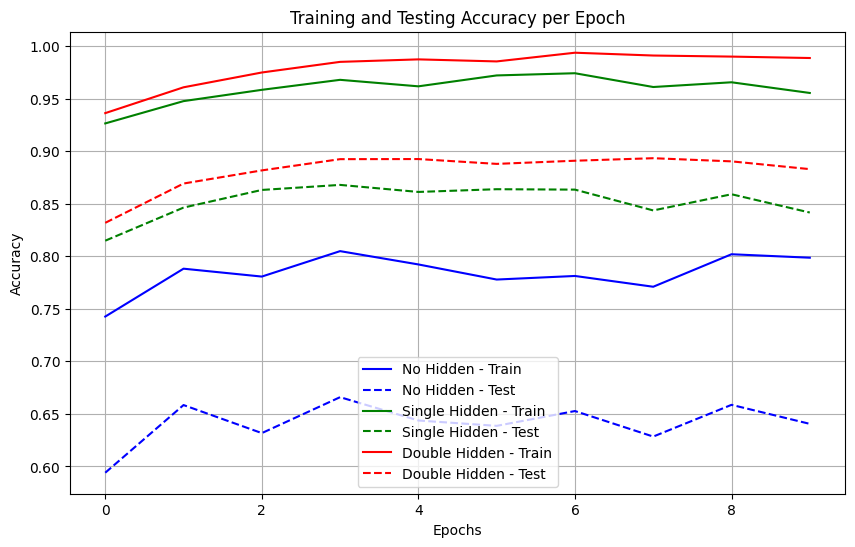

In [ ]:

def plot_acc(train_acc, test_acc, label, color):
    plt.plot(train_acc, label=f'{label} - Train', linestyle='-', color=color)
    plt.plot(test_acc, label=f'{label} - Test', linestyle='--', color=color)

plt.figure(figsize=(10, 6))
plot_acc(no_train_acc, no_test_acc, 'No Hidden', 'blue')
plot_acc(single_train_acc, single_test_acc, 'Single Hidden', 'green')
plot_acc(double_train_acc, double_test_acc, 'Double Hidden', 'red')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#best hidden sizes experiment
best_size_single = 128
best_size_double = 128

no_hidden_final = MLP(input_size=784, hidden_layers=[], activation='relu', output_size=10)
no_hidden_final.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128)
y_pred_no = no_hidden_final.predict(X_te_std)
acc_no = evaluate_acc(y_te, y_pred_no)
print(f"No Hidden Layer Test Accuracy: {acc_no:.4f}")

single_hidden_final = MLP(input_size=784, hidden_layers=[best_size_single], activation='relu', output_size=10)
single_hidden_final.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128)
y_pred_single = single_hidden_final.predict(X_te_std)
acc_single = evaluate_acc(y_te, y_pred_single)
print(f"Single Hidden Layer [{best_size_single}] Test Accuracy: {acc_single:.4f}")

double_hidden_final = MLP(input_size=784, hidden_layers=[best_size_double, best_size_double], activation='relu', output_size=10)
double_hidden_final.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128)
y_pred_double = double_hidden_final.predict(X_te_std)
acc_double = evaluate_acc(y_te, y_pred_double)
print(f"Double Hidden Layer [{best_size_double}, {best_size_double}] Test Accuracy: {acc_double:.4f}")

Epoch 1/10, Loss: 0.9661, Train Acc: 0.7600
Epoch 2/10, Loss: 0.8893, Train Acc: 0.7842
Epoch 3/10, Loss: 0.8991, Train Acc: 0.7767
Epoch 4/10, Loss: 0.8251, Train Acc: 0.7949
Epoch 5/10, Loss: 0.7857, Train Acc: 0.8091
Epoch 6/10, Loss: 0.8111, Train Acc: 0.7971
Epoch 7/10, Loss: 0.8107, Train Acc: 0.7906
Epoch 8/10, Loss: 0.8165, Train Acc: 0.8049
Epoch 9/10, Loss: 0.8517, Train Acc: 0.7919
Epoch 10/10, Loss: 0.8161, Train Acc: 0.7987
No Hidden Layer Test Accuracy: 0.6461
Epoch 1/10, Loss: 0.2568, Train Acc: 0.9225
Epoch 2/10, Loss: 0.2040, Train Acc: 0.9400
Epoch 3/10, Loss: 0.2334, Train Acc: 0.9391
Epoch 4/10, Loss: 0.3188, Train Acc: 0.9293
Epoch 5/10, Loss: 0.3419, Train Acc: 0.9334
Epoch 6/10, Loss: 0.4091, Train Acc: 0.9361
Epoch 7/10, Loss: 0.2357, Train Acc: 0.9541
Epoch 8/10, Loss: 0.2707, Train Acc: 0.9534
Epoch 9/10, Loss: 0.3561, Train Acc: 0.9511
Epoch 10/10, Loss: 0.2193, Train Acc: 0.9642
Single Hidden Layer [128] Test Accuracy: 0.8473
Epoch 1/5, Loss: 0.2223, Train A

In [ ]:
#EXPERIMENT 2 - Using 256 as hidden layer size because most accurate
double_hidden_sigmoid_MLP = MLP(input_size=784, hidden_layers=[256, 256], activation='sigmoid', output_size=10)
double_hidden_sigmoid_MLP.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128)

y_pred_dhsigMLP = double_hidden_sigmoid_MLP.predict(X_te_std)
acc = evaluate_acc(y_te, y_pred_dhsigMLP)
print("Test accuracy double hidden sigmoid MLP:", acc)

double_hidden_leakyReLU_MLP = MLP(input_size=784, hidden_layers=[256, 256], activation='leaky_relu', output_size=10)
double_hidden_leakyReLU_MLP.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128)

y_pred_dhleakyMLP = double_hidden_leakyReLU_MLP.predict(X_te_std)
acc = evaluate_acc(y_te, y_pred_dhleakyMLP)
print("Test accuracy double hidden leaky ReLU MLP:", acc)

double_hidden_relu_MLP = MLP(input_size=784, hidden_layers=[256, 256], activation='relu', output_size=10)
double_hidden_relu_MLP.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128)

y_pred_dhreluMLP = double_hidden_relu_MLP.predict(X_te_std)
acc_relu = evaluate_acc(y_te, y_pred_dhreluMLP)
print("Test accuracy double hidden ReLU MLP:", acc_relu)



Epoch 1/10, Loss: 1.1482, Train Acc: 0.6371
Epoch 2/10, Loss: 0.5547, Train Acc: 0.8351
Epoch 3/10, Loss: 0.3651, Train Acc: 0.8931
Epoch 4/10, Loss: 0.2599, Train Acc: 0.9251
Epoch 5/10, Loss: 0.2064, Train Acc: 0.9411
Epoch 6/10, Loss: 0.1548, Train Acc: 0.9569
Epoch 7/10, Loss: 0.1199, Train Acc: 0.9688
Epoch 8/10, Loss: 0.0919, Train Acc: 0.9771
Epoch 9/10, Loss: 0.0654, Train Acc: 0.9860
Epoch 10/10, Loss: 0.0494, Train Acc: 0.9911
Test accuracy double hidden sigmoid MLP: 0.8766
Epoch 1/10, Loss: 0.2284, Train Acc: 0.9279
Epoch 2/10, Loss: 0.1333, Train Acc: 0.9579
Epoch 3/10, Loss: 0.0706, Train Acc: 0.9791
Epoch 4/10, Loss: 0.0628, Train Acc: 0.9800
Epoch 5/10, Loss: 0.0392, Train Acc: 0.9877
Epoch 6/10, Loss: 0.0353, Train Acc: 0.9891
Epoch 7/10, Loss: 0.0317, Train Acc: 0.9894
Epoch 8/10, Loss: 0.0178, Train Acc: 0.9946
Epoch 9/10, Loss: 0.0188, Train Acc: 0.9938
Epoch 10/10, Loss: 0.0188, Train Acc: 0.9936
Test accuracy double hidden leaky ReLU MLP: 0.8993
Epoch 1/10, Loss: 0

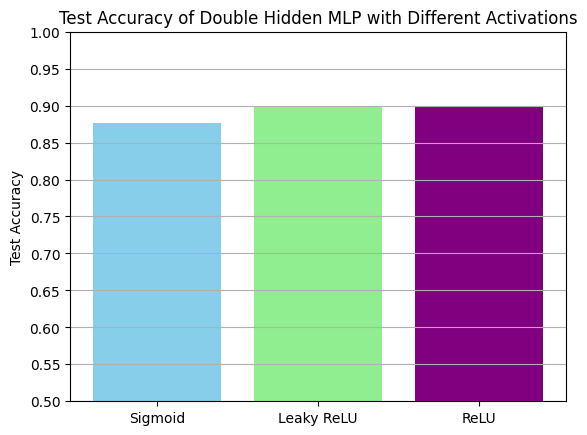

In [ ]:
#for plotting
activations = ['Sigmoid', 'Leaky ReLU', 'ReLU']
accuracies = [
    evaluate_acc(y_te, y_pred_dhsigMLP),
    evaluate_acc(y_te, y_pred_dhleakyMLP),
    acc_relu
]

plt.bar(activations, accuracies, color=['skyblue', 'lightgreen', 'purple'])
plt.title("Test Accuracy of Double Hidden MLP with Different Activations")
plt.ylabel("Test Accuracy")
plt.ylim(0.5, 1)  # Accuracy is between 0 and 1
plt.yticks(np.arange(0.5, 1.01, 0.05))
plt.grid(axis='y')
plt.show()

Epoch 1/10, Loss: 0.2257, Train Acc: 0.9295
Epoch 2/10, Loss: 0.1399, Train Acc: 0.9568
Epoch 3/10, Loss: 0.1004, Train Acc: 0.9684
Epoch 4/10, Loss: 0.0802, Train Acc: 0.9739
Epoch 5/10, Loss: 0.0696, Train Acc: 0.9780
Epoch 6/10, Loss: 0.0518, Train Acc: 0.9836
Epoch 7/10, Loss: 0.0598, Train Acc: 0.9807
Epoch 8/10, Loss: 0.0488, Train Acc: 0.9839
Epoch 9/10, Loss: 0.0291, Train Acc: 0.9904
Epoch 10/10, Loss: 0.0538, Train Acc: 0.9838
Validation accuracy with lambda = 0.0: 0.9432
Epoch 1/10, Loss: 0.2493, Train Acc: 0.9206
Epoch 2/10, Loss: 0.1369, Train Acc: 0.9563
Epoch 3/10, Loss: 0.1182, Train Acc: 0.9613
Epoch 4/10, Loss: 0.0811, Train Acc: 0.9737
Epoch 5/10, Loss: 0.0566, Train Acc: 0.9815
Epoch 6/10, Loss: 0.0532, Train Acc: 0.9826
Epoch 7/10, Loss: 0.0484, Train Acc: 0.9838
Epoch 8/10, Loss: 0.0381, Train Acc: 0.9875
Epoch 9/10, Loss: 0.0320, Train Acc: 0.9891
Epoch 10/10, Loss: 0.0246, Train Acc: 0.9921
Validation accuracy with lambda = 1e-05: 0.9485
Epoch 1/10, Loss: 0.2332

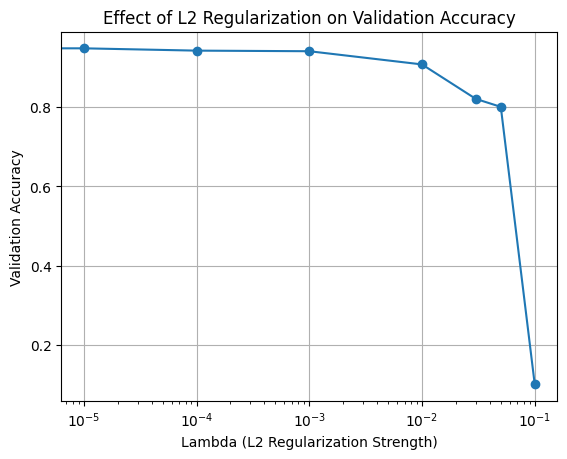

In [ ]:
#EXPERIMENT 3 training model with L2 regularization, takes ~7 minutes to run

#lambda values to test
lambda_values = [0.0, 1e-5, 1e-4, 1e-3, 0.01, 0.03, 0.05, 0.1]

val_accs = {}

for lam in lambda_values:
    model_l2 = MLP(input_size=784, hidden_layers=[128, 128], activation='relu', output_size=10)
    model_l2.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128, reg_lambda=lam)

    y_pred_val = model_l2.predict(X_val_std)
    acc = evaluate_acc(y_val, y_pred_val)

    val_accs[lam] = acc
    print(f"Validation accuracy with lambda = {lam}: {acc:.4f}")


best_lambda = max(val_accs, key=val_accs.get)
print(f"\nBest lambda from validation: {best_lambda}")

#final model on training set
final_model = MLP(input_size=784, hidden_layers=[256, 256], activation='relu', output_size=10)
final_model.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128, reg_lambda=best_lambda)

#evaluate on test set
y_pred_test = final_model.predict(X_te_std)
final_test_acc = evaluate_acc(y_te, y_pred_test)
print(f"Final Test Accuracy with L2 (lambda={best_lambda}): {final_test_acc:.4f}")

lambdas = list(val_accs.keys())
accuracies = list(val_accs.values())

plt.plot(lambdas, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Lambda (L2 Regularization Strength)')
plt.ylabel('Validation Accuracy')
plt.title('Effect of L2 Regularization on Validation Accuracy')
plt.grid(True)
plt.show()



Epoch 1/10, Loss: 0.2307, Train Acc: 0.9300
Epoch 2/10, Loss: 0.1622, Train Acc: 0.9470
Epoch 3/10, Loss: 0.1341, Train Acc: 0.9561
Epoch 4/10, Loss: 0.0901, Train Acc: 0.9705
Epoch 5/10, Loss: 0.0658, Train Acc: 0.9776
Epoch 6/10, Loss: 0.0474, Train Acc: 0.9847
Epoch 7/10, Loss: 0.0404, Train Acc: 0.9869
Epoch 8/10, Loss: 0.0390, Train Acc: 0.9871
Epoch 9/10, Loss: 0.0287, Train Acc: 0.9909
Epoch 10/10, Loss: 0.0271, Train Acc: 0.9913
Validation accuracy with L1 lambda = 0.0: 0.9465
Epoch 1/10, Loss: 0.2887, Train Acc: 0.9034
Epoch 2/10, Loss: 0.1433, Train Acc: 0.9548
Epoch 3/10, Loss: 0.1132, Train Acc: 0.9642
Epoch 4/10, Loss: 0.0805, Train Acc: 0.9749
Epoch 5/10, Loss: 0.0658, Train Acc: 0.9789
Epoch 6/10, Loss: 0.0874, Train Acc: 0.9720
Epoch 7/10, Loss: 0.0511, Train Acc: 0.9830
Epoch 8/10, Loss: 0.0349, Train Acc: 0.9887
Epoch 9/10, Loss: 0.0418, Train Acc: 0.9866
Epoch 10/10, Loss: 0.0319, Train Acc: 0.9896
Validation accuracy with L1 lambda = 1e-05: 0.9487
Epoch 1/10, Loss: 

<ipython-input-5-237559232899>:39: RuntimeWarning: overflow encountered in matmul
  Z = A @ self.weights[-1] + self.biases[-1]
<ipython-input-4-60fe1fd001fb>:22: RuntimeWarning: invalid value encountered in subtract
  exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # stability


Epoch 1/10, Loss: nan, Train Acc: 0.1000
Epoch 2/10, Loss: nan, Train Acc: 0.1000
Epoch 3/10, Loss: nan, Train Acc: 0.1000
Epoch 4/10, Loss: nan, Train Acc: 0.1000
Epoch 5/10, Loss: nan, Train Acc: 0.1000
Epoch 6/10, Loss: nan, Train Acc: 0.1000
Epoch 7/10, Loss: nan, Train Acc: 0.1000
Epoch 8/10, Loss: nan, Train Acc: 0.1000
Epoch 9/10, Loss: nan, Train Acc: 0.1000
Epoch 10/10, Loss: nan, Train Acc: 0.1000
Validation accuracy with L1 lambda = 0.1: 0.1000

Best L1 lambda from validation: 1e-05
Epoch 1/10, Loss: 0.2266, Train Acc: 0.9295
Epoch 2/10, Loss: 0.1175, Train Acc: 0.9640
Epoch 3/10, Loss: 0.0884, Train Acc: 0.9730
Epoch 4/10, Loss: 0.0864, Train Acc: 0.9713
Epoch 5/10, Loss: 0.0565, Train Acc: 0.9814
Epoch 6/10, Loss: 0.0445, Train Acc: 0.9859
Epoch 7/10, Loss: 0.0503, Train Acc: 0.9838
Epoch 8/10, Loss: 0.0597, Train Acc: 0.9830
Epoch 9/10, Loss: 0.0368, Train Acc: 0.9870
Epoch 10/10, Loss: 0.0108, Train Acc: 0.9970
Final Test Accuracy with L1 (lambda=1e-05): 0.9055


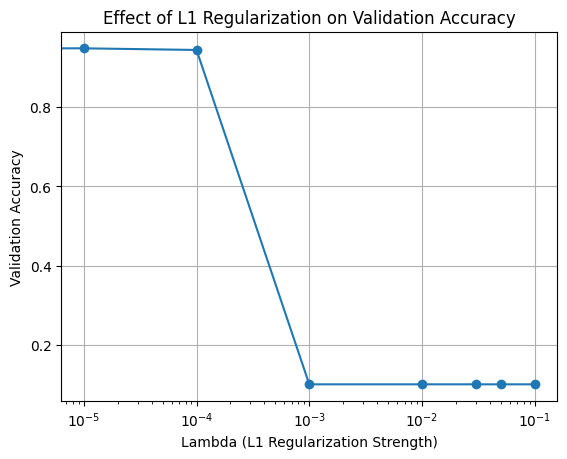

In [ ]:
#CREATIVE EXPERIMENT: L1 REGULARIZATION

#lambda values to test
lambda_values = [0.0, 1e-5, 1e-4, 1e-3, 0.01, 0.03, 0.05, 0.1]

val_accs_l1 = {}

for lam in lambda_values:
    model_l1 = MLP(input_size=784, hidden_layers=[128, 128], activation='relu', output_size=10)
    model_l1.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128, reg_lambda=lam, reg_type='l1')

    y_pred_val = model_l1.predict(X_val_std)
    acc = evaluate_acc(y_val, y_pred_val)

    val_accs_l1[lam] = acc
    print(f"Validation accuracy with L1 lambda = {lam}: {acc:.4f}")

best_lambda_l1 = max(val_accs_l1, key=val_accs_l1.get)
print(f"\nBest L1 lambda from validation: {best_lambda_l1}")

#final model on training set with best L1 lambda
final_model_l1 = MLP(input_size=784, hidden_layers=[256, 256], activation='relu', output_size=10)
final_model_l1.fit(X_tr_std, y_tr, lr=0.5, num_epochs=10, batch_size=128, reg_lambda=best_lambda_l1, reg_type='l1')


y_pred_test_l1 = final_model_l1.predict(X_te_std)
final_test_acc_l1 = evaluate_acc(y_te, y_pred_test_l1)
print(f"Final Test Accuracy with L1 (lambda={best_lambda_l1}): {final_test_acc_l1:.4f}")

#plot
lambdas = list(val_accs_l1.keys())
accuracies = list(val_accs_l1.values())

plt.plot(lambdas, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Lambda (L1 Regularization Strength)')
plt.ylabel('Validation Accuracy')
plt.title('Effect of L1 Regularization on Validation Accuracy')
plt.grid(True)
plt.show()



In [ ]:
#EXPERIMENT 4 imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [ ]:
def plot_history(history, units):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Training vs Validation Accuracy ({units} units)")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
#EXPERIMENT 4 data reshaping
X_tr = np.load("kmnist-train-imgs.npz")["arr_0"]
y_tr = np.load("kmnist-train-labels.npz")["arr_0"]

X_tr = X_tr / 255.0
X_te = X_te / 255.0

X_tr = X_tr.reshape(-1, 28, 28, 1)
X_te = X_te.reshape(-1, 28, 28, 1)

#one-hot encode labels
y_tr_cat = to_categorical(y_tr, num_classes=10)
y_te_cat = to_categorical(y_te, num_classes=10)

#validation set
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr_cat, test_size=0.1, random_state=42)


In [ ]:
#EXPERIMENT 4 model definition

def build_cnn(hidden_units):
    model = models.Sequential()

    #Conv layers with ReLU
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))

    model.add(layers.Flatten())

    #Fully connected layers with ReLU
    model.add(layers.Dense(hidden_units, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # Output layer

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



 Training model with 32 hidden units


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 55s 59ms/step - accuracy: 0.7626 - loss: 0.7253 - val_accuracy: 0.9472 - val_loss: 0.1710
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.9630 - loss: 0.1208 - val_accuracy: 0.9643 - val_loss: 0.1159
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.9770 - loss: 0.0765 - val_accuracy: 0.9720 - val_loss: 0.0904
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 57ms/step - accuracy: 0.9847 - loss: 0.0492 - val_accuracy: 0.9805 - val_loss: 0.0672
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - accuracy: 0.9888 - loss: 0.0346 - val_accuracy: 0.9783 - val_loss: 0.0800


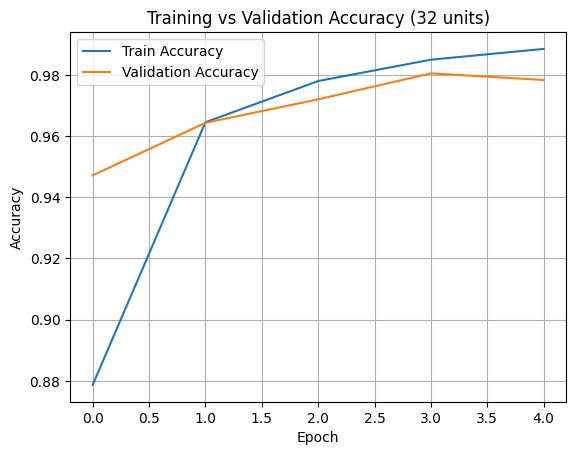


 Training model with 64 hidden units
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 53s 61ms/step - accuracy: 0.7823 - loss: 0.6750 - val_accuracy: 0.9597 - val_loss: 0.1342
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step - accuracy: 0.9660 - loss: 0.1117 - val_accuracy: 0.9742 - val_loss: 0.0908
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 60ms/step - accuracy: 0.9807 - loss: 0.0641 - val_accuracy: 0.9783 - val_loss: 0.0739
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.9876 - loss: 0.0403 - val_accuracy: 0.9798 - val_loss: 0.0646
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 83s 60ms/step - accuracy: 0.9912 - loss: 0.0276 - val_accuracy: 0.9772 - val_loss: 0.0775


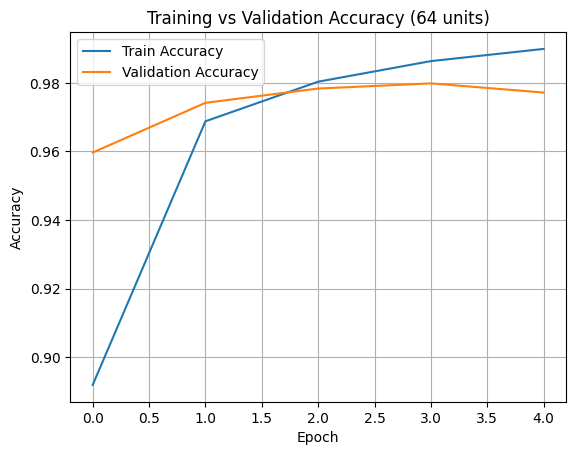


 Training model with 128 hidden units
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 55s 63ms/step - accuracy: 0.7956 - loss: 0.6340 - val_accuracy: 0.9593 - val_loss: 0.1337
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 52s 62ms/step - accuracy: 0.9694 - loss: 0.1027 - val_accuracy: 0.9738 - val_loss: 0.0836
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 62ms/step - accuracy: 0.9833 - loss: 0.0548 - val_accuracy: 0.9807 - val_loss: 0.0684
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.9889 - loss: 0.0359 - val_accuracy: 0.9798 - val_loss: 0.0664
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 61ms/step - accuracy: 0.9912 - loss: 0.0253 - val_accuracy: 0.9793 - val_loss: 0.0717


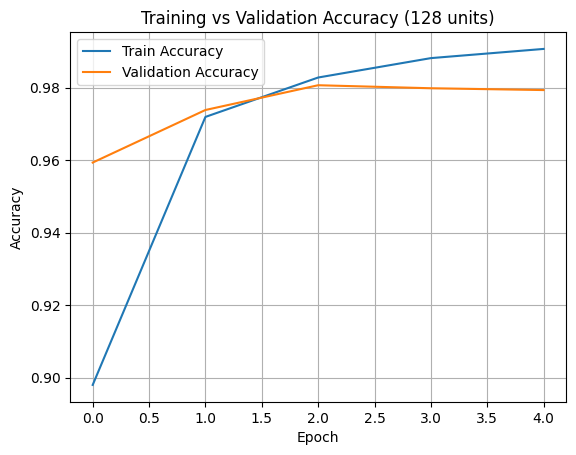


 Training model with 256 hidden units
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 58s 66ms/step - accuracy: 0.8019 - loss: 0.6111 - val_accuracy: 0.9680 - val_loss: 0.1047
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.9718 - loss: 0.0890 - val_accuracy: 0.9772 - val_loss: 0.0734
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.9839 - loss: 0.0515 - val_accuracy: 0.9782 - val_loss: 0.0732
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 83s 65ms/step - accuracy: 0.9893 - loss: 0.0340 - val_accuracy: 0.9798 - val_loss: 0.0709
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.9935 - loss: 0.0209 - val_accuracy: 0.9752 - val_loss: 0.0827


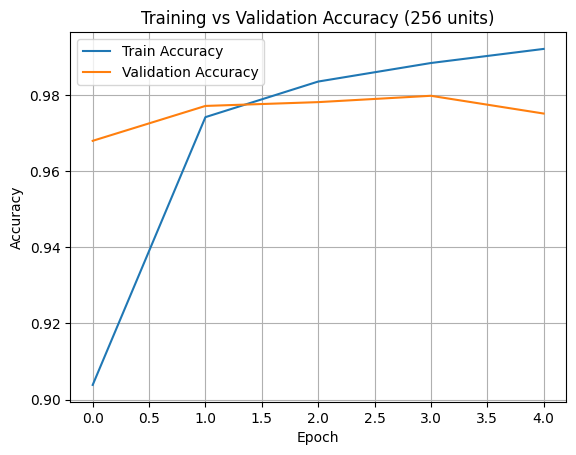


 Validation Accuracies:
32 hidden units: 0.9783
64 hidden units: 0.9772
128 hidden units: 0.9793
256 hidden units: 0.9752

 Best hidden units: 128


In [ ]:
#EXPERIMENT 4 hyperparameter tuning
fc_units_list = [32, 64, 128, 256]
results = {}

for units in fc_units_list:
    print(f"\n Training model with {units} hidden units")
    model = build_cnn(hidden_units=units)
    history = model.fit(X_train, y_train, epochs=5, batch_size=64,
                        validation_data=(X_val, y_val), verbose=1)

    plot_history(history, units)

    val_acc = history.history['val_accuracy'][-1]
    results[units] = val_acc

#display results
print("\n Validation Accuracies:")
for units, acc in results.items():
    print(f"{units} hidden units: {acc:.4f}")

#best
best_units = max(results, key=results.get)
print(f"\n Best hidden units: {best_units}")


In [ ]:
#EXPERIEMENT 4 evaluate model with best hyperparameters
best_model = build_cnn(hidden_units=best_units)
best_model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)
test_loss, test_acc = best_model.evaluate(X_te, y_te_cat)
print(f"\n Test accuracy: {test_acc:.4f}")


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 51s 59ms/step - accuracy: 0.7767 - loss: 0.6968
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.9688 - loss: 0.1038
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 50s 59ms/step - accuracy: 0.9830 - loss: 0.0579
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.9885 - loss: 0.0374
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 48s 57ms/step - accuracy: 0.9911 - loss: 0.0275
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9444 - loss: 0.2211

 Test accuracy: 0.9433
